In [1]:
import FTIR_functions as FTIR
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

import ipywidgets as widgets
from IPython.display import display

plt.rcParams.update({"image.cmap": 'Greys_r', 'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True, "font.size": 16})

In [2]:
############# STEP 0 : OPEN IMAGE FILE ##################

cam1, cam2 = {}, {} # a class would probibly be better for this but I am more familiar with dictionaries.

cam1["label"], cam2["label"] = "Purple", "Xeva"
cam1["source"], cam2["source"] = "big", "big" # Source nickname as it appears in the file name. "blue" "green" "red" "FBH800" "ir" "FBH1600" "big"
cam1["run"], cam2["run"] = 18, 13 # Run number (see excel metadata)
cam1["file_type"], cam2["file_type"] = ".tif", ".csv" # file type
cam1["ref"], cam2["ref"] = 0, 3 # Referance image. This image will be processed into the spectrum

cam1["fringes"], cam1["beamA"], cam1["beamB"], cam1["background"] = FTIR.import_standard_photo(cam1["source"], cam1["run"], cam1["file_type"])
cam2["fringes"], cam2["beamA"], cam2["beamB"], cam2["background"] = FTIR.import_standard_photo(cam2["source"], cam2["run"], cam2["file_type"])

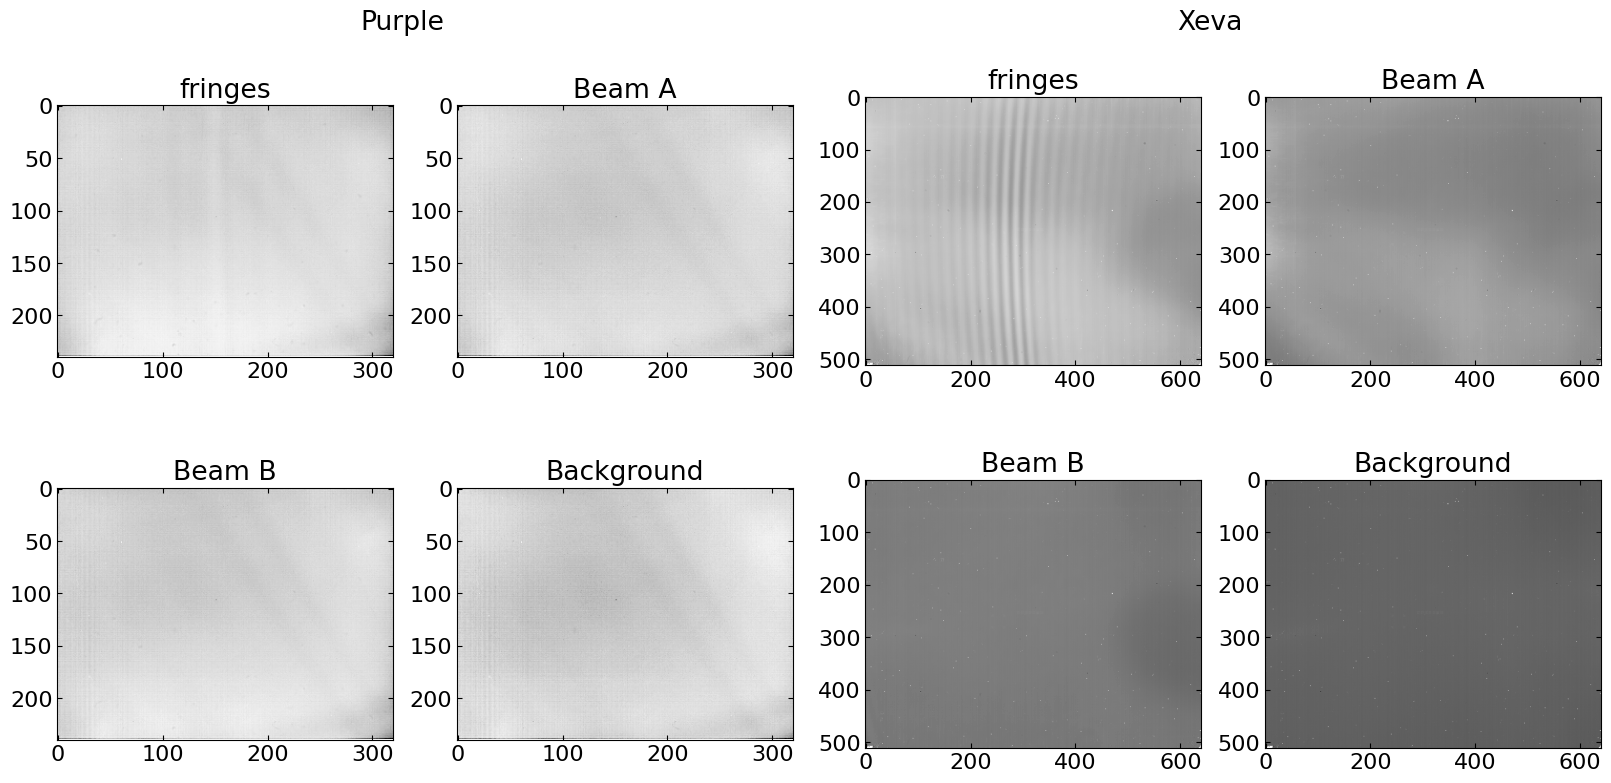

In [3]:
fig = plt.figure(layout= "constrained", figsize= (16, 8))
subfigs = fig.subfigures(1, 2)

cam1["axs"] = subfigs[0].subplots(2, 2)
cam1["axs"] = cam1["axs"].flatten()
subfigs[0].suptitle(cam1["label"])

im1 = cam1["axs"][0].imshow(cam1["fringes"][:,:,cam1["ref"]])
cam1["axs"][0].set(title= "fringes")

cam1["axs"][1].imshow(cam1["beamA"])
cam1["axs"][1].set(title= "Beam A")

cam1["axs"][2].imshow(cam1["beamB"])
cam1["axs"][2].set(title= "Beam B")

cam1["axs"][3].imshow(cam1["background"])
cam1["axs"][3].set(title= "Background")


cam2["axs"] = subfigs[1].subplots(2, 2)
cam2["axs"] = cam2["axs"].flatten()
subfigs[1].suptitle(cam2["label"])

im2 = cam2["axs"][0].imshow(cam2["fringes"][:,:,cam2["ref"]])
cam2["axs"][0].set(title= "fringes")

cam2["axs"][1].imshow(cam2["beamA"])
cam2["axs"][1].set(title= "Beam A")

cam2["axs"][2].imshow(cam2["beamB"])
cam2["axs"][2].set(title= "Beam B")

cam2["axs"][3].imshow(cam2["background"])
cam2["axs"][3].set(title= "Background")

plt.show()

In [4]:
########### STEP 1: BACKGROUND SUBTRACT ############

cam1["fringes_subtracted"], cam1["no_fringes"] = FTIR.bg_subtract(cam1["fringes"], cam1["beamA"], cam1["beamB"], cam1["background"], dead_pixels= 0)
cam2["fringes_subtracted"], cam2["no_fringes"] = FTIR.bg_subtract(cam2["fringes"], cam2["beamA"], cam2["beamB"], cam2["background"], dead_pixels= 0)
#fringes_subtracted = fringes_subtracted[1:,:,:] #what is this for? I forgot!

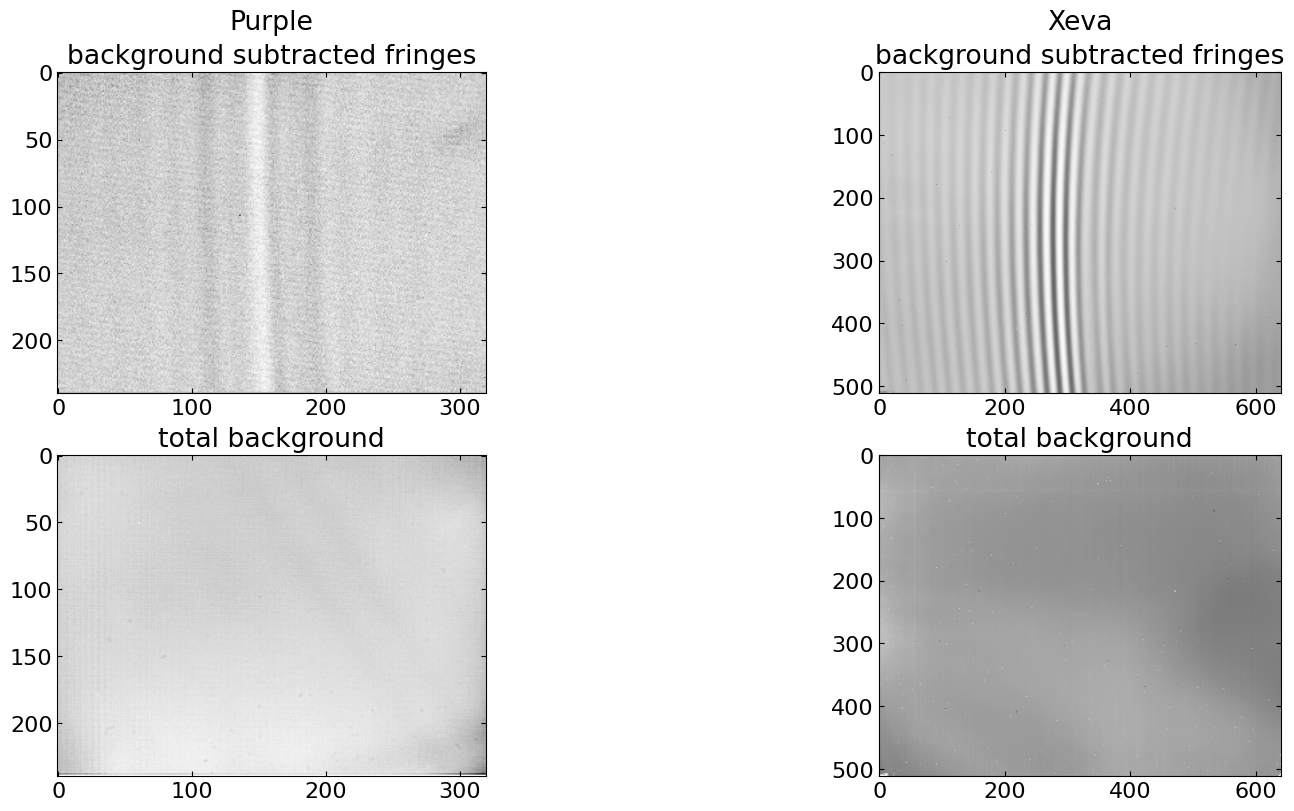

In [5]:
fig = plt.figure(layout= "constrained", figsize= (16, 8))
subfigs = fig.subfigures(1, 2)

cam1["axs"] = subfigs[0].subplots(2, 1)
cam1["axs"] = cam1["axs"].flatten()
subfigs[0].suptitle(cam1["label"])

im1 = cam1["axs"][0].imshow(cam1["fringes_subtracted"][:,:,cam1["ref"]])
cam1["axs"][0].set(title= "background subtracted fringes")

im2 = cam1["axs"][1].imshow(cam1["no_fringes"][:,:,cam1["ref"]])
cam1["axs"][1].set(title= "total background")


cam2["axs"] = subfigs[1].subplots(2, 1)
cam2["axs"] = cam2["axs"].flatten()
subfigs[1].suptitle(cam2["label"])

im3 = cam2["axs"][0].imshow(cam2["fringes_subtracted"][:,:,cam2["ref"]])
cam2["axs"][0].set(title= "background subtracted fringes")

im4 = cam2["axs"][1].imshow(cam2["no_fringes"][:,:,cam2["ref"]])
cam2["axs"][1].set(title= "total background")

plt.show()

In [6]:
########### STEP 2: MAKE 1D #############

cam1["nickname"], cam2["nickname"] = "purple", "xeva" # camera nickname. "manta" "xeva" "purple" "pyro"

for cam in [cam1, cam2]:
    if cam["nickname"] == "manta":
        cam["pixel_pitch"] = 9.9 #um
    elif cam["nickname"] == "xeva":
        cam["pixel_pitch"] = 20 #um
    elif cam["nickname"] == "purple":
        cam["pixel_pitch"] = 48.5 #um
    elif cam["nickname"] == "pyro":
        cam["pixel_pitch"] = 80 #um
    else:
        raise ValueError(cam["nickname"] + " is not a valid camera.")

    cam["rows"], cam["columns"] = cam["fringes_subtracted"][:,:,cam["ref"]].shape
    cam["length"] = cam["columns"]*cam["pixel_pitch"]*1e-3 # in mm
    cam["height"] = cam["rows"]*cam["pixel_pitch"]*1e-3 # in mm

    cam["FT2d"] = np.fft.fftshift(np.fft.fft2(cam["fringes_subtracted"][:,:,cam["ref"]], norm= "forward"))

    cam["k_x"] = np.fft.fftshift(np.fft.fftfreq(cam["columns"], cam["pixel_pitch"]*1e-3)) #in mm^-1
    cam["k_y"] = np.fft.fftshift(np.fft.fftfreq(cam["rows"], cam["pixel_pitch"]*1e-3))

    cam["dk_x"] = 1 /(cam["rows"]*cam["pixel_pitch"]*1e-3)
    cam["dk_y"] = 1 /(cam["columns"]*cam["pixel_pitch"]*1e-3)

    cam["x_extent"]=  (-cam["pixel_pitch"]*1e-3/2, cam["length"] +cam["pixel_pitch"]*1e-3/2,
                    -   cam["pixel_pitch"]*1e-3/2, cam["height"] +cam["pixel_pitch"]*1e-3/2)

    cam["k_extent"]= (cam["k_x"][0] -cam["dk_x"]/2, cam["k_x"][-1] +cam["dk_x"]/2,
                      cam["k_y"][0] -cam["dk_y"]/2, cam["k_y"][-1] +cam["dk_y"]/2)


In [7]:
# Define the function to plot
def plot_function(alpha1, alpha2):
    fig = plt.figure(layout= "constrained", figsize= (16, 8))
    subfigs = fig.subfigures(2, 1)

    cam1["axs"] = subfigs[0].subplots(1, 3, gridspec_kw= {"wspace": 0.1})

    cam1["x_intercepts"], cam1["y_intercepts"], _ = FTIR.bounding_box((0, cam1["length"]), (0, cam1["height"]), (cam1["length"]/2, cam1["height"]/2), np.tan(alpha1))

    cam1["axs"][0].imshow(cam1["fringes_subtracted"][:,:,cam1["ref"]], origin= "lower", extent= cam1["x_extent"])
    cam1["axs"][0].plot(cam1["x_intercepts"], cam1["y_intercepts"])
    cam1["axs"][0].set(title= "background subtracted fringes", xlabel= "displacement $x$ (mm)", ylabel= "displacement $y$ (mm)")

    cam1["k_x_intercepts"], cam1["k_y_intercepts"], _ = FTIR.bounding_box((cam1["k_x"][0], cam1["k_x"][-1]), (cam1["k_y"][0], cam1["k_y"][-1]), (0,0), np.tan(alpha1))

    cam1["axs"][1].imshow(np.abs(cam1["FT2d"]), origin= "lower", extent= cam1["k_extent"], cmap= "magma_r")
    cam1["axs"][1].plot(0, 0, color= "k", marker= "+", markersize= 16) #crosshair
    cam1["axs"][1].plot(cam1["k_x_intercepts"], cam1["k_y_intercepts"])
    cam1["axs"][1].set(title= "2D fourier transform", xlabel= "wavenumber $x$ (mm$^{-1}$)", ylabel= "wavenumber $y$ (mm$^{-1}$)")

    cam1["x"], cam1["fringes_1d"], _ = FTIR.slice_2d(cam1["fringes_subtracted"][:,:,cam1["ref"]], alpha1)
    cam1["x"] *= cam1["pixel_pitch"] *1e-3
    cam1["fringes_1d"] = FTIR.recenter(cam1["fringes_1d"])

    cam1["axs"][2].plot(cam1["x"], cam1["fringes_1d"]) # When alpha is large, the frequency interpolation becomes more difficult and the S:N at the extremes of r gets worse. Harsher apodization is needed to compensate.
    cam1["axs"][2].set(xlabel= "displacement r (mm)", ylabel= "intensity (arb.)")


    cam2["axs"] = subfigs[1].subplots(1, 3, gridspec_kw= {"wspace": 0.1})

    cam2["x_intercepts"], cam2["y_intercepts"], _ = FTIR.bounding_box((0, cam2["length"]), (0, cam2["height"]), (cam2["length"]/2, cam2["height"]/2), np.tan(alpha2))

    cam2["axs"][0].imshow(cam2["fringes_subtracted"][:,:,cam2["ref"]], origin= "lower", extent= cam2["x_extent"])
    cam2["axs"][0].plot(cam2["x_intercepts"], cam2["y_intercepts"])
    cam2["axs"][0].set(title= "background subtracted fringes", xlabel= "displacement $x$ (mm)", ylabel= "displacement $y$ (mm)")

    cam2["k_x_intercepts"], cam2["k_y_intercepts"], _ = FTIR.bounding_box((cam2["k_x"][0], cam2["k_x"][-1]), (cam2["k_y"][0], cam2["k_y"][-1]), (0,0), np.tan(alpha2))

    cam2["axs"][1].imshow(np.abs(cam2["FT2d"]), origin= "lower", extent= cam2["k_extent"], cmap= "magma_r")
    cam2["axs"][1].plot(0, 0, color= "k", marker= "+", markersize= 16) #crosshair
    cam2["axs"][1].plot(cam2["k_x_intercepts"], cam2["k_y_intercepts"])
    cam2["axs"][1].set(title= "2D fourier transform", xlabel= "wavenumber $x$ (mm$^{-1}$)", ylabel= "wavenumber $y$ (mm$^{-1}$)")

    cam2["x"], cam2["fringes_1d"], _ = FTIR.slice_2d(cam2["fringes_subtracted"][:,:,cam2["ref"]], alpha2)
    cam2["x"] *= cam2["pixel_pitch"] *1e-3
    cam2["fringes_1d"] = FTIR.recenter(cam2["fringes_1d"])

    cam2["axs"][2].plot(cam2["x"], cam2["fringes_1d"]) # When alpha is large, the frequency interpolation becomes more difficult and the S:N at the extremes of r gets worse. Harsher apodization is needed to compensate.
    cam2["axs"][2].set(xlabel= "displacement r (mm)", ylabel= "intensity (arb.)")


    plt.show()

### interactive alpha
decimal_places = 1
alpha1_slider = widgets.BoundedFloatText(value=0.0, min=np.round(-np.pi/2, decimal_places), max=np.round(np.pi/2, decimal_places), step= 10**-decimal_places, description='cam1 alpha (rad):', disabled= False)
alpha2_slider = widgets.BoundedFloatText(value=0.0, min=np.round(-np.pi/2, decimal_places), max=np.round(np.pi/2, decimal_places), step= 10**-decimal_places, description='cam2 alpha (rad):', disabled= False)

### auto button
cam1_button = widgets.Button(description='Auto cam1 alpha', button_style='info')
def auto_cam1(button):
    alpha1_slider.value = FTIR.find_alpha(cam1["fringes_subtracted"][:,:,cam1["ref"]])  # Set the slider value to a predefined value
cam1_button.on_click(auto_cam1)

cam2_button = widgets.Button(description='Auto cam2 alpha', button_style='info')
def auto_cam2(button):
    alpha2_slider.value = FTIR.find_alpha(cam2["fringes_subtracted"][:,:,cam2["ref"]])  # Set the slider value to a predefined value
cam2_button.on_click(auto_cam2)

### display widgets and interactive plot
interactive_plot = widgets.interact(plot_function, alpha1=alpha1_slider, alpha2=alpha2_slider)
display(cam1_button, cam2_button)


interactive(children=(BoundedFloatText(value=0.0, description='cam1 alpha (rad):', max=1.6, min=-1.6, step=0.1…

Button(button_style='info', description='Auto cam1 alpha', style=ButtonStyle())

Button(button_style='info', description='Auto cam2 alpha', style=ButtonStyle())

In [8]:
########### STEP 3: APODIZATION #############

cam1["alpha"] = alpha1_slider.value
cam2["alpha"] = alpha2_slider.value

_, cam1["fringes_1d"], _ = FTIR.slice_2d(cam1["fringes_subtracted"][:,:,cam1["ref"]], cam1["alpha"])
_, cam2["fringes_1d"], _ = FTIR.slice_2d(cam2["fringes_subtracted"][:,:,cam2["ref"]], cam2["alpha"])
cam1["fringes_1d"] = FTIR.recenter(cam1["fringes_1d"])
cam2["fringes_1d"] = FTIR.recenter(cam2["fringes_1d"])

cam1["fringes_apodized"] = FTIR.apodization(cam1["fringes_1d"], function= ["happ-genzel", "triangular"])
cam2["fringes_apodized"] = FTIR.apodization(cam2["fringes_1d"], function= ["happ-genzel", "triangular"])


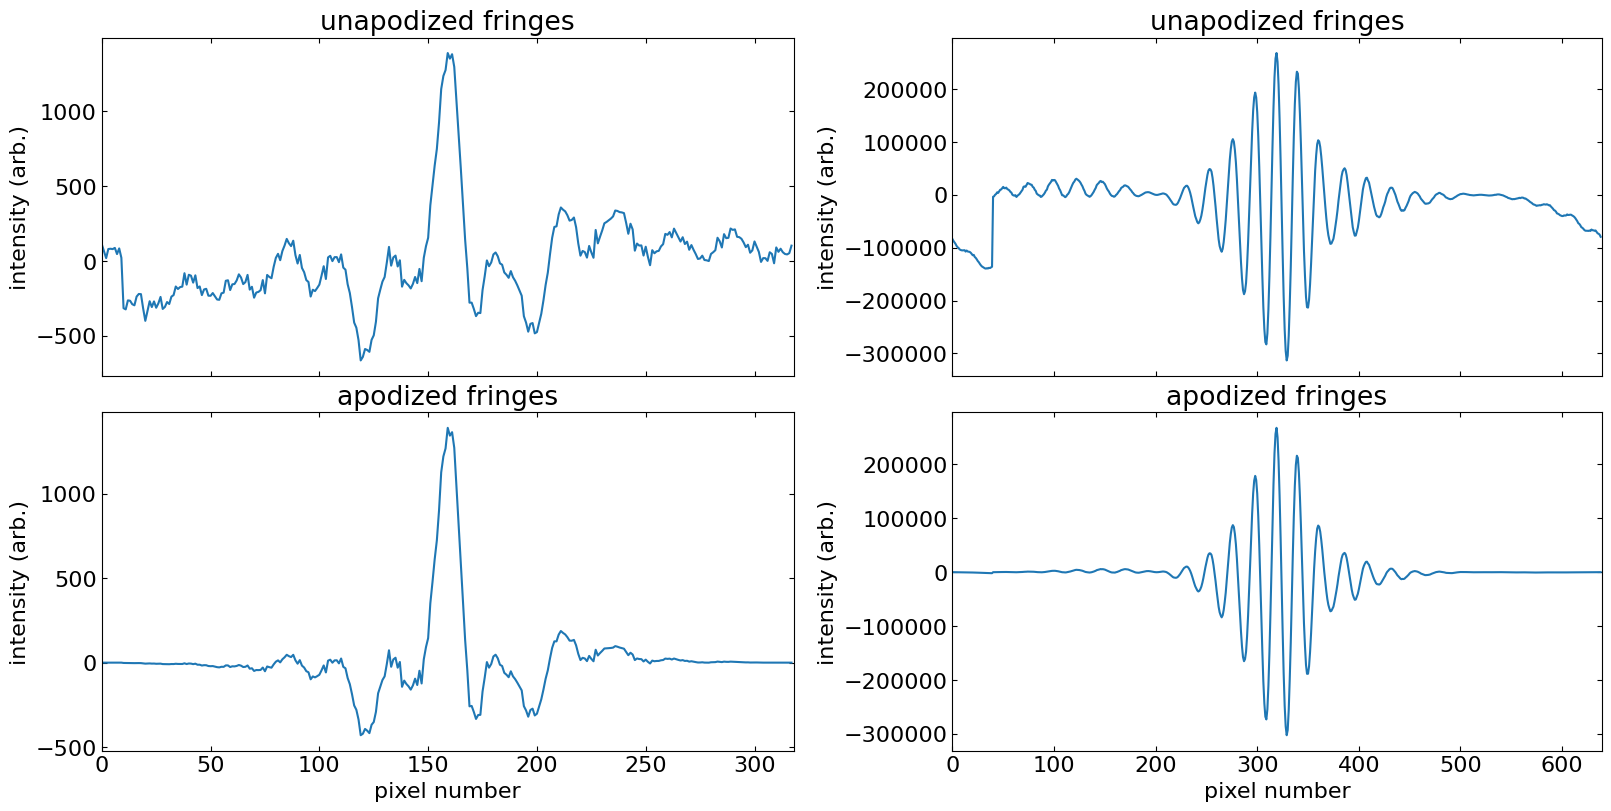

In [9]:
fig = plt.figure(layout= "constrained", figsize= (16, 8))
subfigs = fig.subfigures(1, 2)

cam1["axs"] = subfigs[0].subplots(2, 1, sharex= True)

cam1["axs"][0].plot(cam1["fringes_1d"])
cam1["axs"][0].set(ylabel= "intensity (arb.)", title= "unapodized fringes", xlim= (0, len(cam1["fringes_1d"])))

cam1["axs"][1].plot(cam1["fringes_apodized"])
cam1["axs"][1].set(xlabel= "pixel number", ylabel= "intensity (arb.)", title= "apodized fringes", xlim= (0, len(cam1["fringes_1d"])))


cam2["axs"] = subfigs[1].subplots(2, 1, sharex= True)

cam2["axs"][0].plot(cam2["fringes_1d"])
cam2["axs"][0].set(ylabel= "intensity (arb.)", title= "unapodized fringes", xlim= (0, len(cam2["fringes_1d"])))

cam2["axs"][1].plot(cam2["fringes_apodized"])
cam2["axs"][1].set(xlabel= "pixel number", ylabel= "intensity (arb.)", title= "apodized fringes", xlim= (0, len(cam2["fringes_1d"])))

plt.show()

In [10]:
########### STEP 4: ZERO PADDING #############

zero_padding = 4 # Make the interferogram `zero_padding` times longer by adding zeros to the start and end

cam1["fringes_padded"] = FTIR.zero_pad(cam1["fringes_apodized"], zero_padding= zero_padding)
cam2["fringes_padded"] = FTIR.zero_pad(cam2["fringes_apodized"], zero_padding= zero_padding)

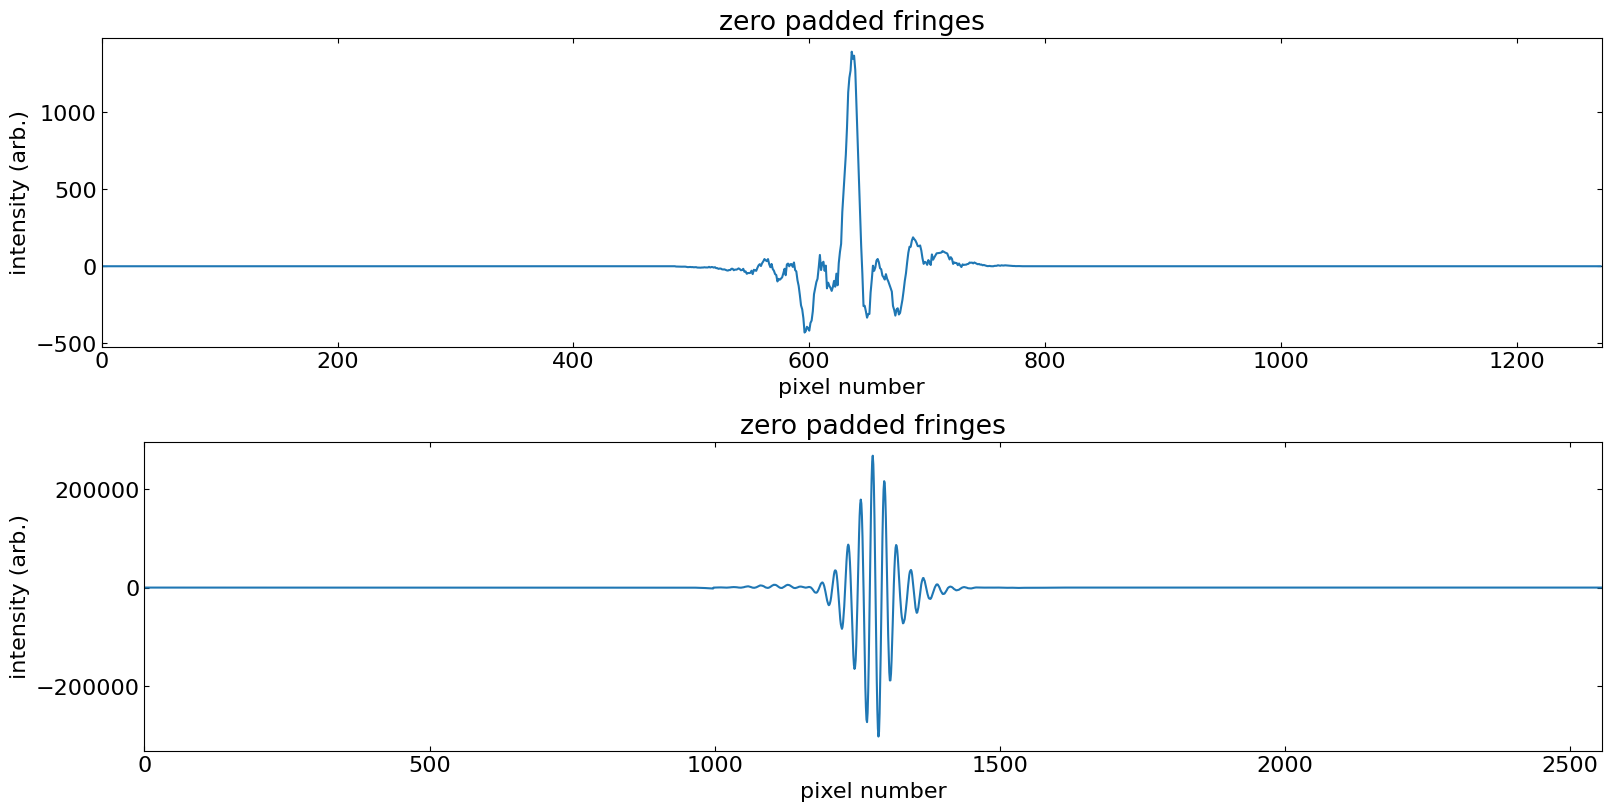

In [11]:
fig = plt.figure(layout= "constrained", figsize= (16, 8))
subfigs = fig.subfigures(2, 1)

cam1["axs"] = subfigs[0].subplots(1, 1)

cam1["axs"].plot(cam1["fringes_padded"])
cam1["axs"].set(xlabel= "pixel number", ylabel= "intensity (arb.)", title= "zero padded fringes", xlim= (0, len(cam1["fringes_padded"])))


cam2["axs"] = subfigs[1].subplots(1, 1)

cam2["axs"].plot(cam2["fringes_padded"])
cam2["axs"].set(xlabel= "pixel number", ylabel= "intensity (arb.)", title= "zero padded fringes", xlim= (0, len(cam2["fringes_padded"])))

plt.show()

In [12]:
########### STEP 5: FOURIER TRANSFORM #############

cam1["theta"], cam2["theta"] = 4.60, 5.85  #arcminutes

cam1["spectrum"], cam1["freqs"] = FTIR.power_spectrum_FT(cam1["fringes_padded"], cam1["theta"], cam1["pixel_pitch"])
cam2["spectrum"], cam2["freqs"] = FTIR.power_spectrum_FT(cam2["fringes_padded"], cam2["theta"], cam2["pixel_pitch"])
cam1["spectrum"] /= np.max(cam1["spectrum"])
cam2["spectrum"] /= np.max(cam2["spectrum"])

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


In [13]:
# Define the function to plot
def plot_function(sensitive_range1, sensitive_range2):
    
    fig = plt.figure(layout= "constrained", figsize= (16, 8))
    subfigs = fig.subfigures(2, 1)

    cam1["axs"] = subfigs[0].subplots(1, 1)

    cam1["axs"].plot(cam1["freqs"]*1e-12, cam1["spectrum"])
    cam1["axs"].vlines(sensitive_range1, ymin= 0, ymax= 1, colors= "silver", transform= cam1["axs"].get_xaxis_transform())
    cam1["axs"].set(xlabel= "frequency (THz)", ylabel= "amplitude (arb.)")

    cam1["secax"] = cam1["axs"].secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))
    cam1["secax"].set(xlabel= "wavelength ($\mu$m)", xticks= FTIR.recip(cam1["axs"].get_xticks()[0 < cam1["axs"].get_xticks()]))
    cam1["secax"].xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))


    cam2["axs"] = subfigs[1].subplots(1, 1)

    cam2["axs"].plot(cam2["freqs"]*1e-12, cam2["spectrum"])
    cam2["axs"].vlines(sensitive_range2, ymin= 0, ymax= 1, colors= "silver", transform= cam2["axs"].get_xaxis_transform())
    cam2["axs"].set(xlabel= "frequency (THz)", ylabel= "amplitude (arb.)")

    cam2["secax"] = cam2["axs"].secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))
    cam2["secax"].set(xlabel= "wavelength ($\mu$m)", xticks= FTIR.recip(cam2["axs"].get_xticks()[0 < cam2["axs"].get_xticks()]))
    cam2["secax"].xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))

    plt.show()

# Create interactive range slider for min and max x values
range1_slider = widgets.FloatRangeSlider(value=[0, max(cam1["freqs"])*1e-12], min=0, max=max(cam1["freqs"])*1e-12, step=10, description='Cam1 sensitive range:', readout_format='.0f', layout= widgets.Layout(width= "70%"))
range2_slider = widgets.FloatRangeSlider(value=[0, max(cam2["freqs"])*1e-12], min=0, max=max(cam2["freqs"])*1e-12, step=10, description='Cam2 sensitive range:', readout_format='.0f', layout= widgets.Layout(width= "70%"))


# Connect the range slider to the plot function
interactive_plot = widgets.interact(plot_function, sensitive_range1=range1_slider, sensitive_range2=range2_slider)


interactive(children=(FloatRangeSlider(value=(0.0, 1154.8754616114502), description='Cam1 sensitive range:', l…

In [14]:
########### STEP 6: FORM FACTOR #############

model = "ginzberg-frank"
phase_retrival = "gerchberg_saxon" #"kramers_kronig"

cam1["sensitive_range"] = range1_slider.value
cam2["sensitive_range"] = range2_slider.value
cam1["sensitivity_mask"] = np.logical_and(cam1["sensitive_range"][0]*1e12 <= cam1["freqs"], cam1["freqs"] <= cam1["sensitive_range"][1]*1e12)
cam2["sensitivity_mask"] = np.logical_and(cam2["sensitive_range"][0]*1e12 <= cam2["freqs"], cam2["freqs"] <= cam2["sensitive_range"][1]*1e12)

In [15]:
cam1["df"] = np.median(np.diff(cam1["freqs"])) #I should probably use the formulas instead
cam2["df"] = np.median(np.diff(cam2["freqs"]))
cam1["nyquist"] = np.max(cam1["freqs"])
cam2["nyquist"] = np.max(cam2["freqs"])

### COMBINE SPECTRA
# Because the amplitude is arbatry, it is impossible to know what the relitive amplitudes are supposed to be. This could be solved if you could figure out the intensity (in W/m^2) or the flux hitting the cameras.

cams = {}

cams["df"] = np.min((cam1["df"], cam2["df"]))
cams["nyquist"] = np.max((cam1["nyquist"], cam2["nyquist"]))
cams["freqs"] = np.arange(0, cams["nyquist"] +cams["df"]/2, cams["df"])
cams["sensitivity_mask"] = np.logical_or(np.logical_and(cam1["sensitive_range"][0]*1e12 <= cams["freqs"], cams["freqs"] <= cam1["sensitive_range"][1]*1e12),
                                         np.logical_and(cam2["sensitive_range"][0]*1e12 <= cams["freqs"], cams["freqs"] <= cam2["sensitive_range"][1]*1e12))

cams["dt"] = 0.5/cams["nyquist"]
cams["duration"] = 1/cams["df"]
cams["time"] = np.arange(0, cams["duration"] -cams["dt"]/2, cams["dt"])

all_measured_freqs = np.concatenate([cam1["freqs"][cam1["sensitivity_mask"]], cam2["freqs"][cam2["sensitivity_mask"]]])
all_measured_spectra = np.concatenate([cam1["spectrum"][cam1["sensitivity_mask"]], cam2["spectrum"][cam2["sensitivity_mask"]]])
_, sort = np.unique(all_measured_freqs, return_index= True)
cams["spectrum"] = np.interp(cams["freqs"], all_measured_freqs[sort], all_measured_spectra[sort]) # NP.INTERP WILL ALSO EXTRAPOLATE. It does linear interpolation and nearest neighbor extrapolation.

In [16]:
if model == "ginzberg-frank":
    cams["FF"] = cams["spectrum"] # The Ginzberg-Frank formula shows no dependence between the intensity and the frequency
# Other models get very complicated very quickly but it would be nice to add some.
    

cams["phase"] = np.zeros_like(cams["freqs"])

match phase_retrival:
    case "kramers_kronig":
        cams["phase"][cams["sensitivity_mask"]] = FTIR.kramers_kronig(cams["freqs"][cams["sensitivity_mask"]], np.sqrt(cams["FF"][cams["sensitivity_mask"]]))
        cams["CFF"] = np.sqrt(cams["FF"] *cams["sensitivity_mask"]) *np.exp(1j*cams["phase"]) #apply phase
    case "gerchberg_saxon":
        cams["CFF"] = FTIR.gerchberg_saxon(np.sqrt(cams["FF"]), sensitivity_mask= cams["sensitivity_mask"], tolerance= 0.2)
        cams["phase"] = np.angle(cams["CFF"])


cams["bunch"] = np.fft.irfft(cams["CFF"], norm= "forward") #inverse fourier transform
cams["bunch"] /= np.max(cams["bunch"]) #normalise

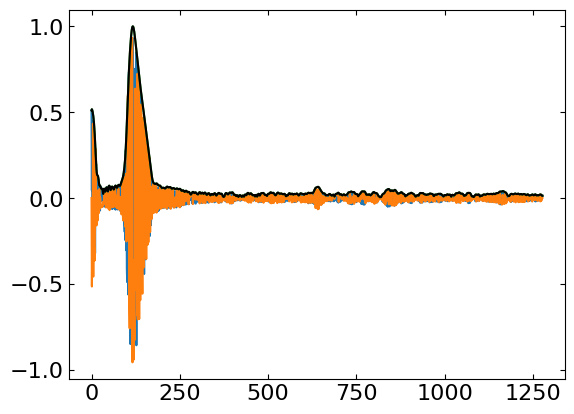

In [17]:
plt.plot(cams["CFF"].real)
plt.plot(cams["CFF"].imag)
plt.plot(np.abs(cams["CFF"]))
plt.plot(np.sqrt(cams["FF"]), color= "k")
plt.show()

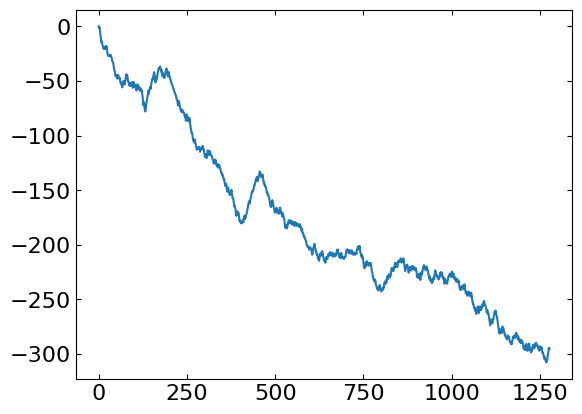

In [18]:
plt.plot(np.unwrap(cams["phase"]))
plt.show()

In [19]:
# Define the function to plot
def plot_function(time_offset):
    
    cams["CFF"] = np.abs(cams["CFF"]) *np.exp(1j*cams["phase"]) *np.exp(-2j*np.pi*cams["freqs"]*time_offset*1e-15)#apply phase
    cams["bunch"] = np.fft.irfft(cams["CFF"], norm= "forward") #inverse fourier transform
    cams["bunch"] /= np.max(cams["bunch"]) #normalise

    fig, axs = plt.subplots(1, 1, figsize= (12, 8))

    axs.plot(cams["time"]*1e15, cams["bunch"])
    axs.set(xlabel= "time (fs)", ylabel= "bunch profile (arb.)", ylim= (-1.2,1.2))

    plt.show()

offset_slider = widgets.FloatSlider(value=0, min=0, max=max(cams["time"])*1e15, step=10, description='Peak time:', readout_format='.0f', layout= widgets.Layout(width= "70%"))

# Connect the range slider to the plot function
interactive_plot = widgets.interact(plot_function, time_offset=offset_slider)

interactive(children=(FloatSlider(value=0.0, description='Peak time:', layout=Layout(width='70%'), max=579.885…

In [20]:
########### STEP 7: MAKE A NICE GRAPH :) #############

temporal_offset = offset_slider.value

cams["CFF"] = np.abs(cams["CFF"]) *np.exp(1j*cams["phase"]) *np.exp(-2j*np.pi*cams["freqs"]*temporal_offset*1e-15)#apply phase
cams["bunch"] = np.fft.irfft(cams["CFF"], norm= "forward") #inverse fourier transform
cams["bunch"] /= np.max(cams["bunch"]) #normalise

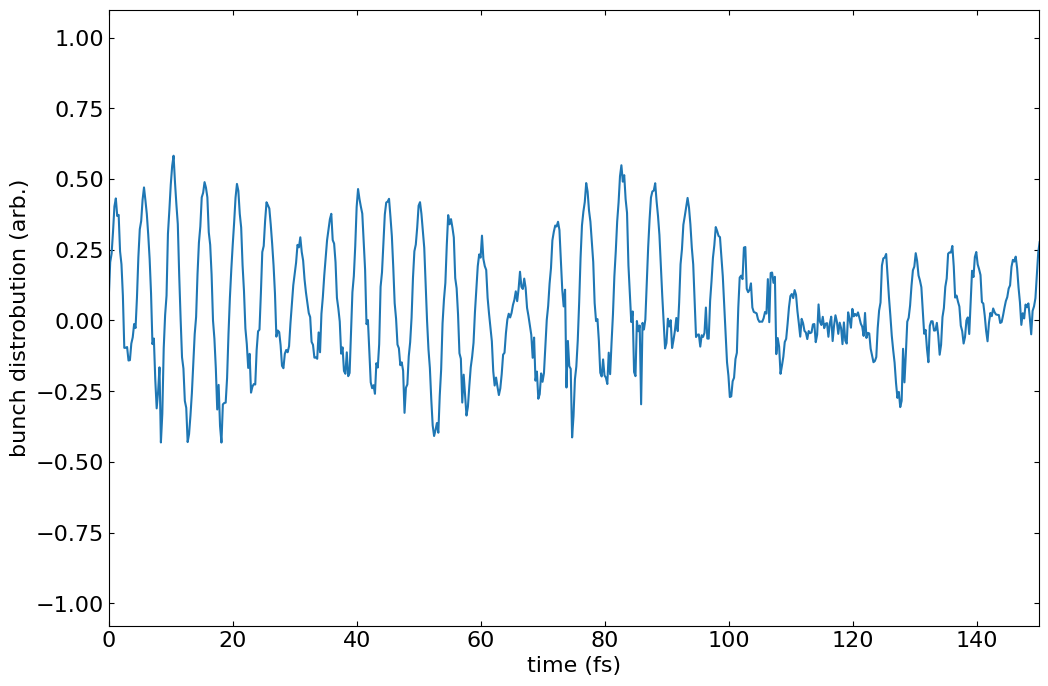

In [21]:
fig, axs = plt.subplots(1, 1, figsize= (12, 8))

axs.plot(cams["time"]*1e15, cams["bunch"])
axs.set(xlabel= "time (fs)", ylabel= "bunch distrobution (arb.)", xlim= (0, 150))

fig.savefig("graphs\\purple_and_xeva_bunch")
plt.show()